# Importing Necessary Packages

In [73]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [74]:
# Load metadata
metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
metadata = pd.read_csv(metadata_path)

In [75]:
metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


# Explore metadata

In [76]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

# Handle Missing Values

In [77]:
# Check for missing values
missing_values_count = metadata.isnull().sum()

# Calculate the percentage of missing values for each column
missing_values_percentage = ((metadata.isnull().sum() / len(metadata)) * 100).round(2)

# Combine the count and percentage into a DataFrame
missing_info = pd.DataFrame({
    'Missing Count': missing_values_count,
    'Missing Percentage': missing_values_percentage
})

# Filter and display only columns with missing values
missing_info = missing_info[missing_info['Missing Count'] > 0]
pd.DataFrame(missing_info)

,Missing Count,Missing Percentage
age_approx,2798,0.70
sex,11517,2.87
anatom_site_general,5756,1.44
lesion_id,379001,94.50
iddx_2,399991,99.73
iddx_3,399994,99.73
iddx_4,400508,99.86
iddx_5,401058,100.00
mel_mitotic_index,401006,99.99
mel_thick_mm,400996,99.98


In [78]:
# Drop columns with high percentage of missing values
columns_to_remove = ['lesion_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm']
metadata.drop(columns_to_remove, axis = 1, inplace = True, errors = 'ignore')
metadata.shape

(401059, 48)

In [79]:
# Group by the 'target' column and count missing values for each column
missing_by_target = metadata.groupby('target').apply(lambda x: x.isnull().sum())

# Filter columns that have any missing values
missing_by_target = missing_by_target.loc[:, (missing_by_target > 0).any()]
missing_by_target

,age_approx,sex,anatom_site_general
target,,,
0,2795,11507,5756
1,3,10,0


In [80]:
# Fill missing values in other columns
metadata.ffill(inplace = True)
metadata.isna().sum()

isic_id                         0
target                          0
patient_id                      0
age_approx                      0
sex                             0
anatom_site_general             0
clin_size_long_diam_mm          0
image_type                      0
tbp_tile_type                   0
tbp_lv_A                        0
tbp_lv_Aext                     0
tbp_lv_B                        0
tbp_lv_Bext                     0
tbp_lv_C                        0
tbp_lv_Cext                     0
tbp_lv_H                        0
tbp_lv_Hext                     0
tbp_lv_L                        0
tbp_lv_Lext                     0
tbp_lv_areaMM2                  0
tbp_lv_area_perim_ratio         0
tbp_lv_color_std_mean           0
tbp_lv_deltaA                   0
tbp_lv_deltaB                   0
tbp_lv_deltaL                   0
tbp_lv_deltaLB                  0
tbp_lv_deltaLBnorm              0
tbp_lv_eccentricity             0
tbp_lv_location                 0
tbp_lv_locatio

# Data Preprocessing

In [81]:
# Iterate over each object column and get unique values and counts
results = []
for col in metadata.select_dtypes(include='object').columns:
    unique_vals = metadata[col].unique()  # Get unique values
    n_unique = metadata[col].nunique()     # Get number of unique values
    results.append({'Column': col, 'Number of Unique Values': n_unique, 'Unique Values': unique_vals})

# Create a DataFrame from the results
unique_df = pd.DataFrame(results)
unique_df

,Column,Number of Unique Values,Unique Values
0,isic_id,401059,"[ISIC_0015670, ISIC_0015845, ISIC_0015864, ISI..."
1,patient_id,1042,"[IP_1235828, IP_8170065, IP_6724798, IP_411138..."
2,sex,2,"[male, female]"
3,anatom_site_general,5,"[lower extremity, head/neck, posterior torso, ..."
4,image_type,1,[TBP tile: close-up]
5,tbp_tile_type,2,"[3D: white, 3D: XP]"
6,tbp_lv_location,21,"[Right Leg - Upper, Head & Neck, Torso Back To..."
7,tbp_lv_location_simple,8,"[Right Leg, Head & Neck, Torso Back, Torso Fro..."
8,attribution,7,"[Memorial Sloan Kettering Cancer Center, ACEMI..."
9,copyright_license,3,"[CC-BY, CC-0, CC-BY-NC]"


In [82]:
# Drop useless columns
metadata.drop(['patient_id','image_type', 'attribution', 'tbp_lv_dnn_lesion_confidence',
               'copyright_license', 'iddx_1','iddx_full'], axis = 1, inplace = True, errors = 'ignore')
metadata.shape

(401059, 41)

# Exploratory Data Analysis

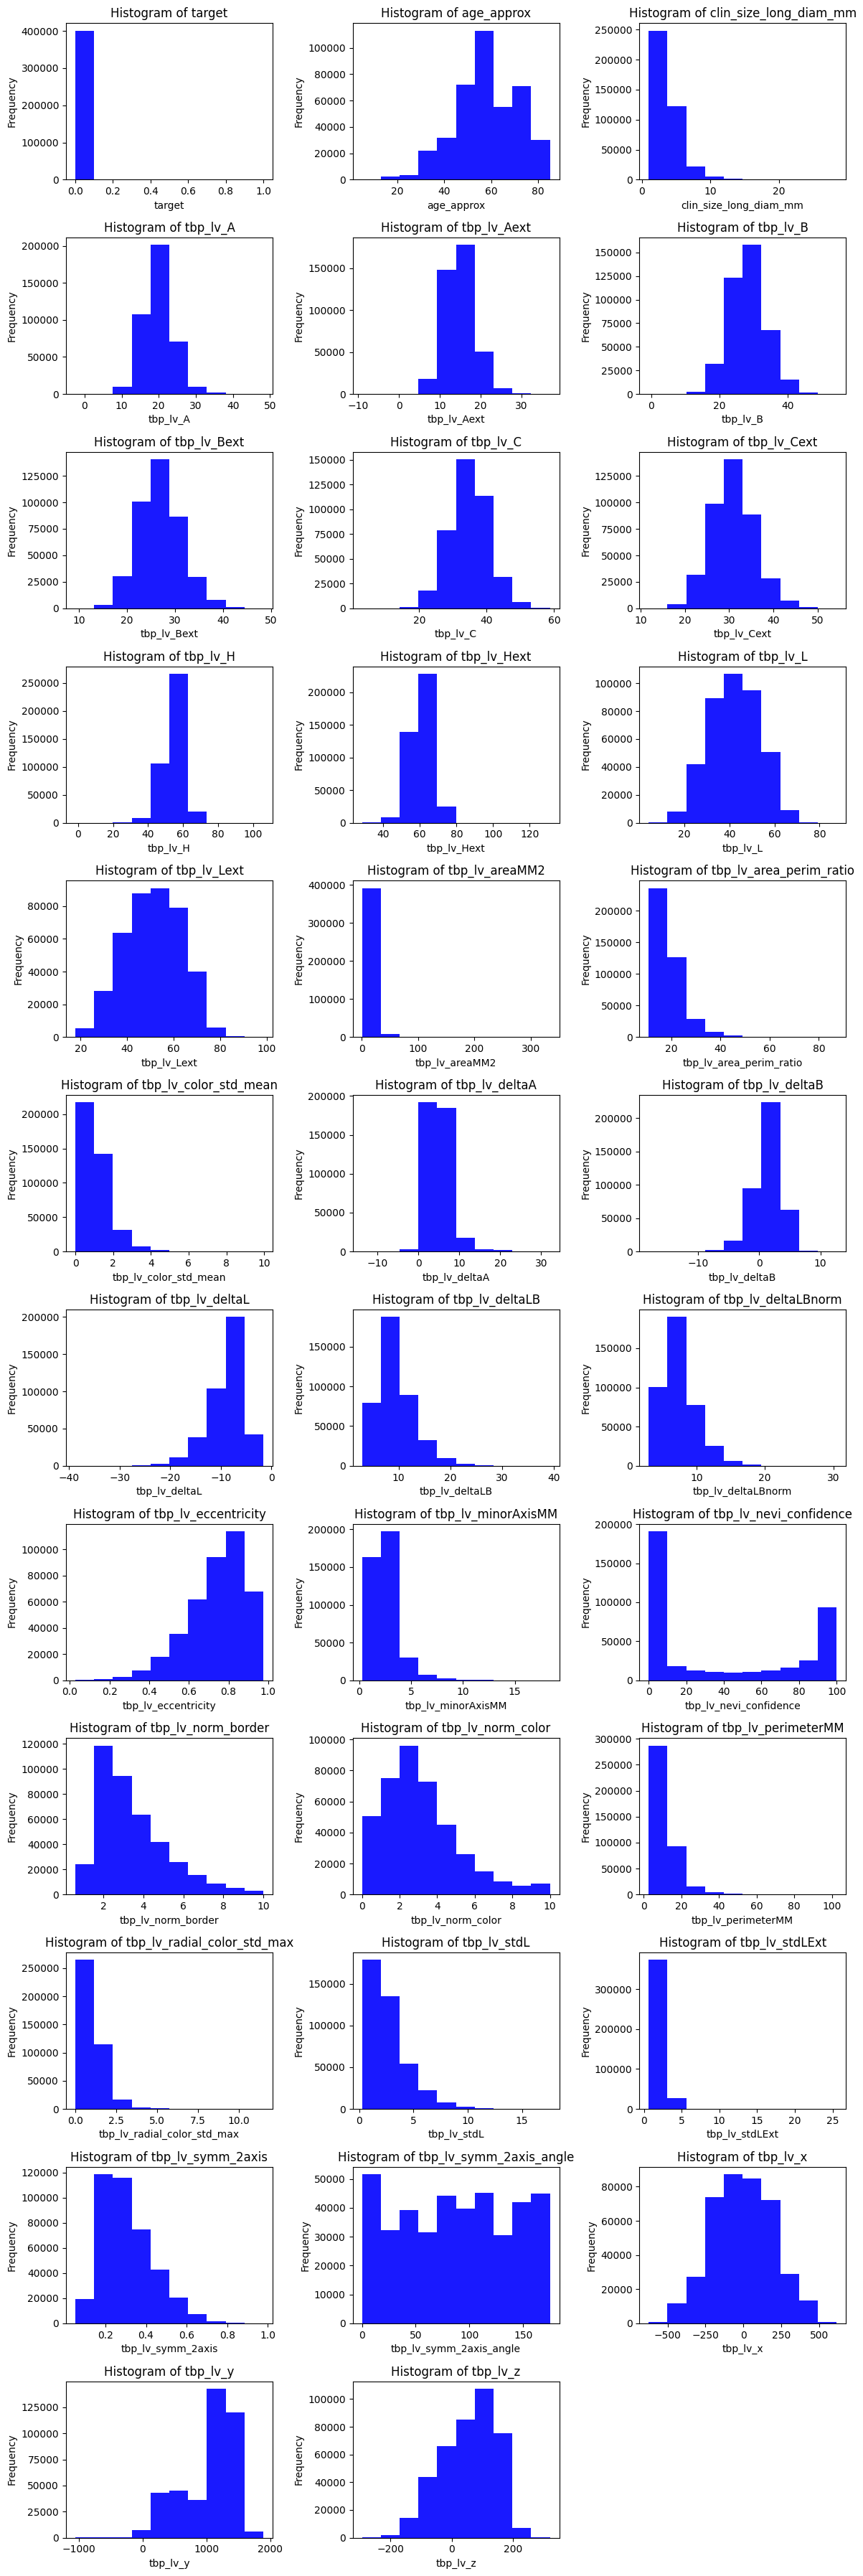

In [83]:
# Select only numeric columns
numeric_columns = metadata.select_dtypes(include='number')

# Set up the plot
num_cols = len(numeric_columns.columns)
fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(12, 3 * ((num_cols // 3) + 1)))
axes = axes.flatten()

# Plot histograms for each numeric column
for i, column in enumerate(numeric_columns.columns):
    axes[i].hist(numeric_columns[column], bins=10, alpha=0.9, color='blue')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('histograms.jpg')
plt.show()

In [84]:
malignant_cases = metadata[metadata['target'] == 1]
benign_cases = metadata[metadata['target'] == 0]

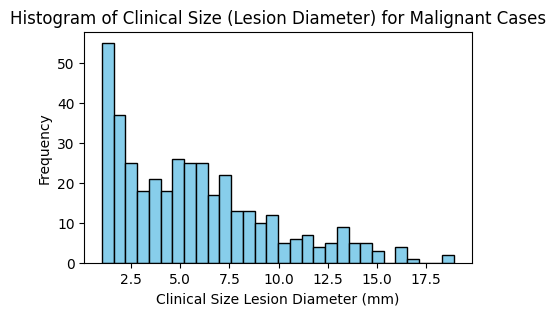

In [85]:
# Plot histogram for 'clin_size_long_diam_mm'
plt.figure(figsize=(5, 3))
plt.hist(malignant_cases['clin_size_long_diam_mm'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Clinical Size (Lesion Diameter) for Malignant Cases')
plt.xlabel('Clinical Size Lesion Diameter (mm)')
plt.ylabel('Frequency')
plt.show()

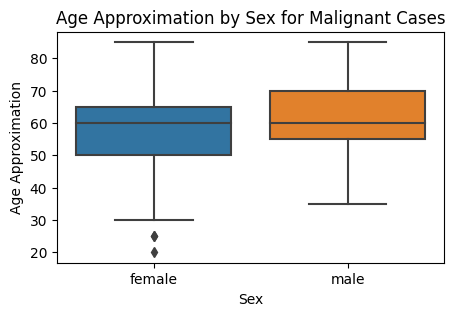

In [86]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='sex', y='age_approx', data=malignant_cases)
plt.title('Age Approximation by Sex for Malignant Cases')
plt.xlabel('Sex')
plt.ylabel('Age Approximation')
plt.show()

### ***From the above plot, we can observe that Women have risk of skin cancer earlier than Men.***

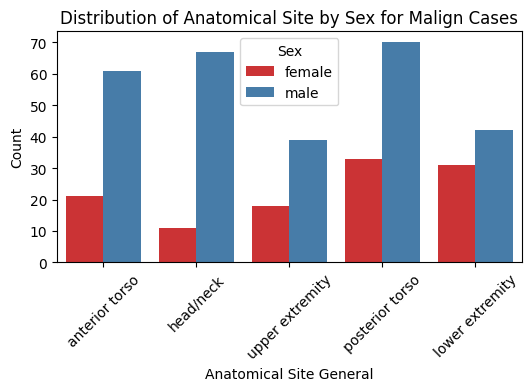

In [87]:
plt.figure(figsize=(6, 3))
sns.countplot(x='anatom_site_general', hue='sex', data=malignant_cases, palette='Set1')
plt.title('Distribution of Anatomical Site by Sex for Malign Cases')
plt.xlabel('Anatomical Site General')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sex')
plt.show()

# Encoding Categorical columns

In [88]:
object_columns = metadata.select_dtypes(include='object')
object_columns.head()

,isic_id,sex,anatom_site_general,tbp_tile_type,tbp_lv_location,tbp_lv_location_simple
0,ISIC_0015670,male,lower extremity,3D: white,Right Leg - Upper,Right Leg
1,ISIC_0015845,male,head/neck,3D: white,Head & Neck,Head & Neck
2,ISIC_0015864,male,posterior torso,3D: XP,Torso Back Top Third,Torso Back
3,ISIC_0015902,male,anterior torso,3D: XP,Torso Front Top Half,Torso Front
4,ISIC_0024200,male,anterior torso,3D: white,Torso Front Top Half,Torso Front


In [89]:
columns_to_encode = object_columns.drop(columns=['isic_id'])
# Create dummy variables for the selected columns
metadata = pd.get_dummies(metadata, columns=columns_to_encode.columns, drop_first=True, dtype = int)
metadata

,isic_id,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,...,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_0015670,0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,...,0,0,0,0,0,0,1,0,0,0
1,ISIC_0015845,0,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,...,0,0,0,0,0,0,0,0,0,0
2,ISIC_0015864,0,60.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,...,0,0,0,0,0,0,0,1,0,0
3,ISIC_0015902,0,65.0,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,...,0,1,0,0,0,0,0,0,1,0
4,ISIC_0024200,0,55.0,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,70.0,6.80,22.574335,14.944666,27.663259,26.767135,35.705132,30.656525,...,0,1,0,0,0,0,0,0,1,0
401055,ISIC_9999951,0,60.0,3.11,19.977640,16.026870,34.158840,31.011870,39.571870,34.908400,...,0,0,0,0,0,0,0,1,0,0
401056,ISIC_9999960,0,65.0,2.05,17.332567,12.364397,29.845326,26.500073,34.513206,29.242644,...,0,1,0,0,0,0,0,0,1,0
401057,ISIC_9999964,0,30.0,2.80,22.288570,9.564721,28.431200,27.012250,36.126360,28.655640,...,1,0,0,0,0,0,0,0,1,0


# Handle Class Imbalance

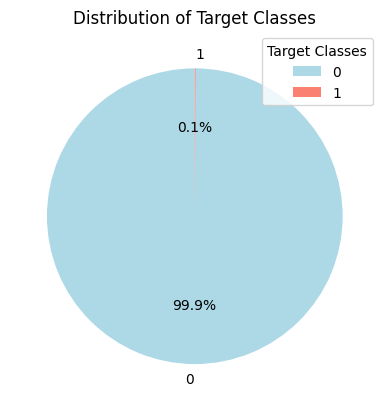

In [90]:
# Calculate value counts for the 'target' column
value_counts = metadata['target'].value_counts()
value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Distribution of Target Classes')
plt.ylabel('')  # Remove the y-label for clarity
plt.legend(title='Target Classes', loc='upper right', labels=value_counts.index)
plt.show()

In [91]:
# Separate majority and minority classes
majority_class = metadata[metadata['target'] ==  0]  # Assuming 0 is the majority class
minority_class = metadata[metadata['target'] == 1]  # Assuming 1 is the minority class

#Undersample the majority class
majority_class_downsampled = resample(majority_class, 
                                       replace=False,  # Do not replace
                                       n_samples=600,  
                                       random_state=42)  # Reproducible results

#Combine the undersampled majority class with the minority class
undersampled_df = pd.concat([majority_class_downsampled, minority_class])
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(undersampled_df['target'].value_counts()) 

target
0    600
1    393
Name: count, dtype: int64


In [92]:
from imblearn.over_sampling import SMOTE

# Separate the isic_id column and keep original indices
isic_ids = undersampled_df['isic_id']

# Prepare data for resampling
data_to_resample = undersampled_df.drop(columns=['isic_id'])

# Separate features and target
X = data_to_resample.drop(columns=['target'])
y = data_to_resample['target']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a DataFrame for resampled features
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['target'] = y_resampled  

# Number of newly generated synthetic samples
num_new_samples = len(X_resampled) - len(X)

# Attach original isic_ids to the first part of the DataFrame
resampled_df['isic_id'] = pd.concat([isic_ids, pd.Series([None] * num_new_samples)], ignore_index=True)

# Reorder columns to make 'isic_id' the first column and 'target' the second
resampled_df = resampled_df[['isic_id', 'target'] + [col for col in resampled_df.columns if col not in ['isic_id', 'target']]]

# Display the resampled DataFrame
resampled_df.head()

,isic_id,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,...,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_Unknown,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front,tbp_lv_location_simple_Unknown
0,ISIC_7745168,1,80.0,13.47,17.562551,14.449421,21.222056,22.026133,27.546667,26.342671,...,0,0,0,0,0,0,0,1,0,0
1,ISIC_5265088,0,60.0,2.93,21.976708,20.164393,22.996255,23.166859,31.808858,30.713289,...,1,0,0,0,0,0,0,0,1,0
2,ISIC_4034820,0,65.0,2.66,17.680250,16.357560,20.018350,24.539160,26.708150,29.491350,...,0,0,0,0,1,0,0,0,0,0
3,ISIC_1186361,1,30.0,7.12,18.964410,14.769880,18.465020,20.541780,26.468960,25.300470,...,0,0,0,0,1,0,0,0,0,0
4,ISIC_7676691,1,55.0,1.23,34.033000,29.418980,24.597730,22.139230,41.991590,36.818780,...,0,1,0,0,0,0,0,0,1,0


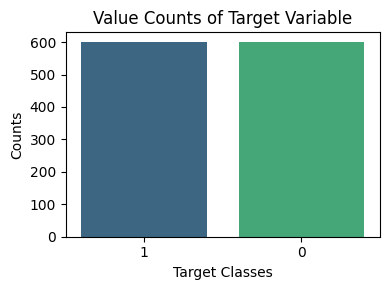

In [93]:
value_counts = resampled_df['target'].value_counts()

# Plotting
plt.figure(figsize=(4, 3))
sns.barplot(x=value_counts.index.astype(str), y=value_counts.values, palette='viridis')  
plt.title('Value Counts of Target Variable')
plt.xlabel('Target Classes')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Feature Selection

In [94]:
(resampled_df['tbp_lv_location_Torso Front'] == 0).sum()

1200

In [95]:
resampled_df.drop(['tbp_lv_location_Torso Front', 'tbp_lv_location_Torso Back'], axis = 1, inplace = True, errors = 'ignore') 

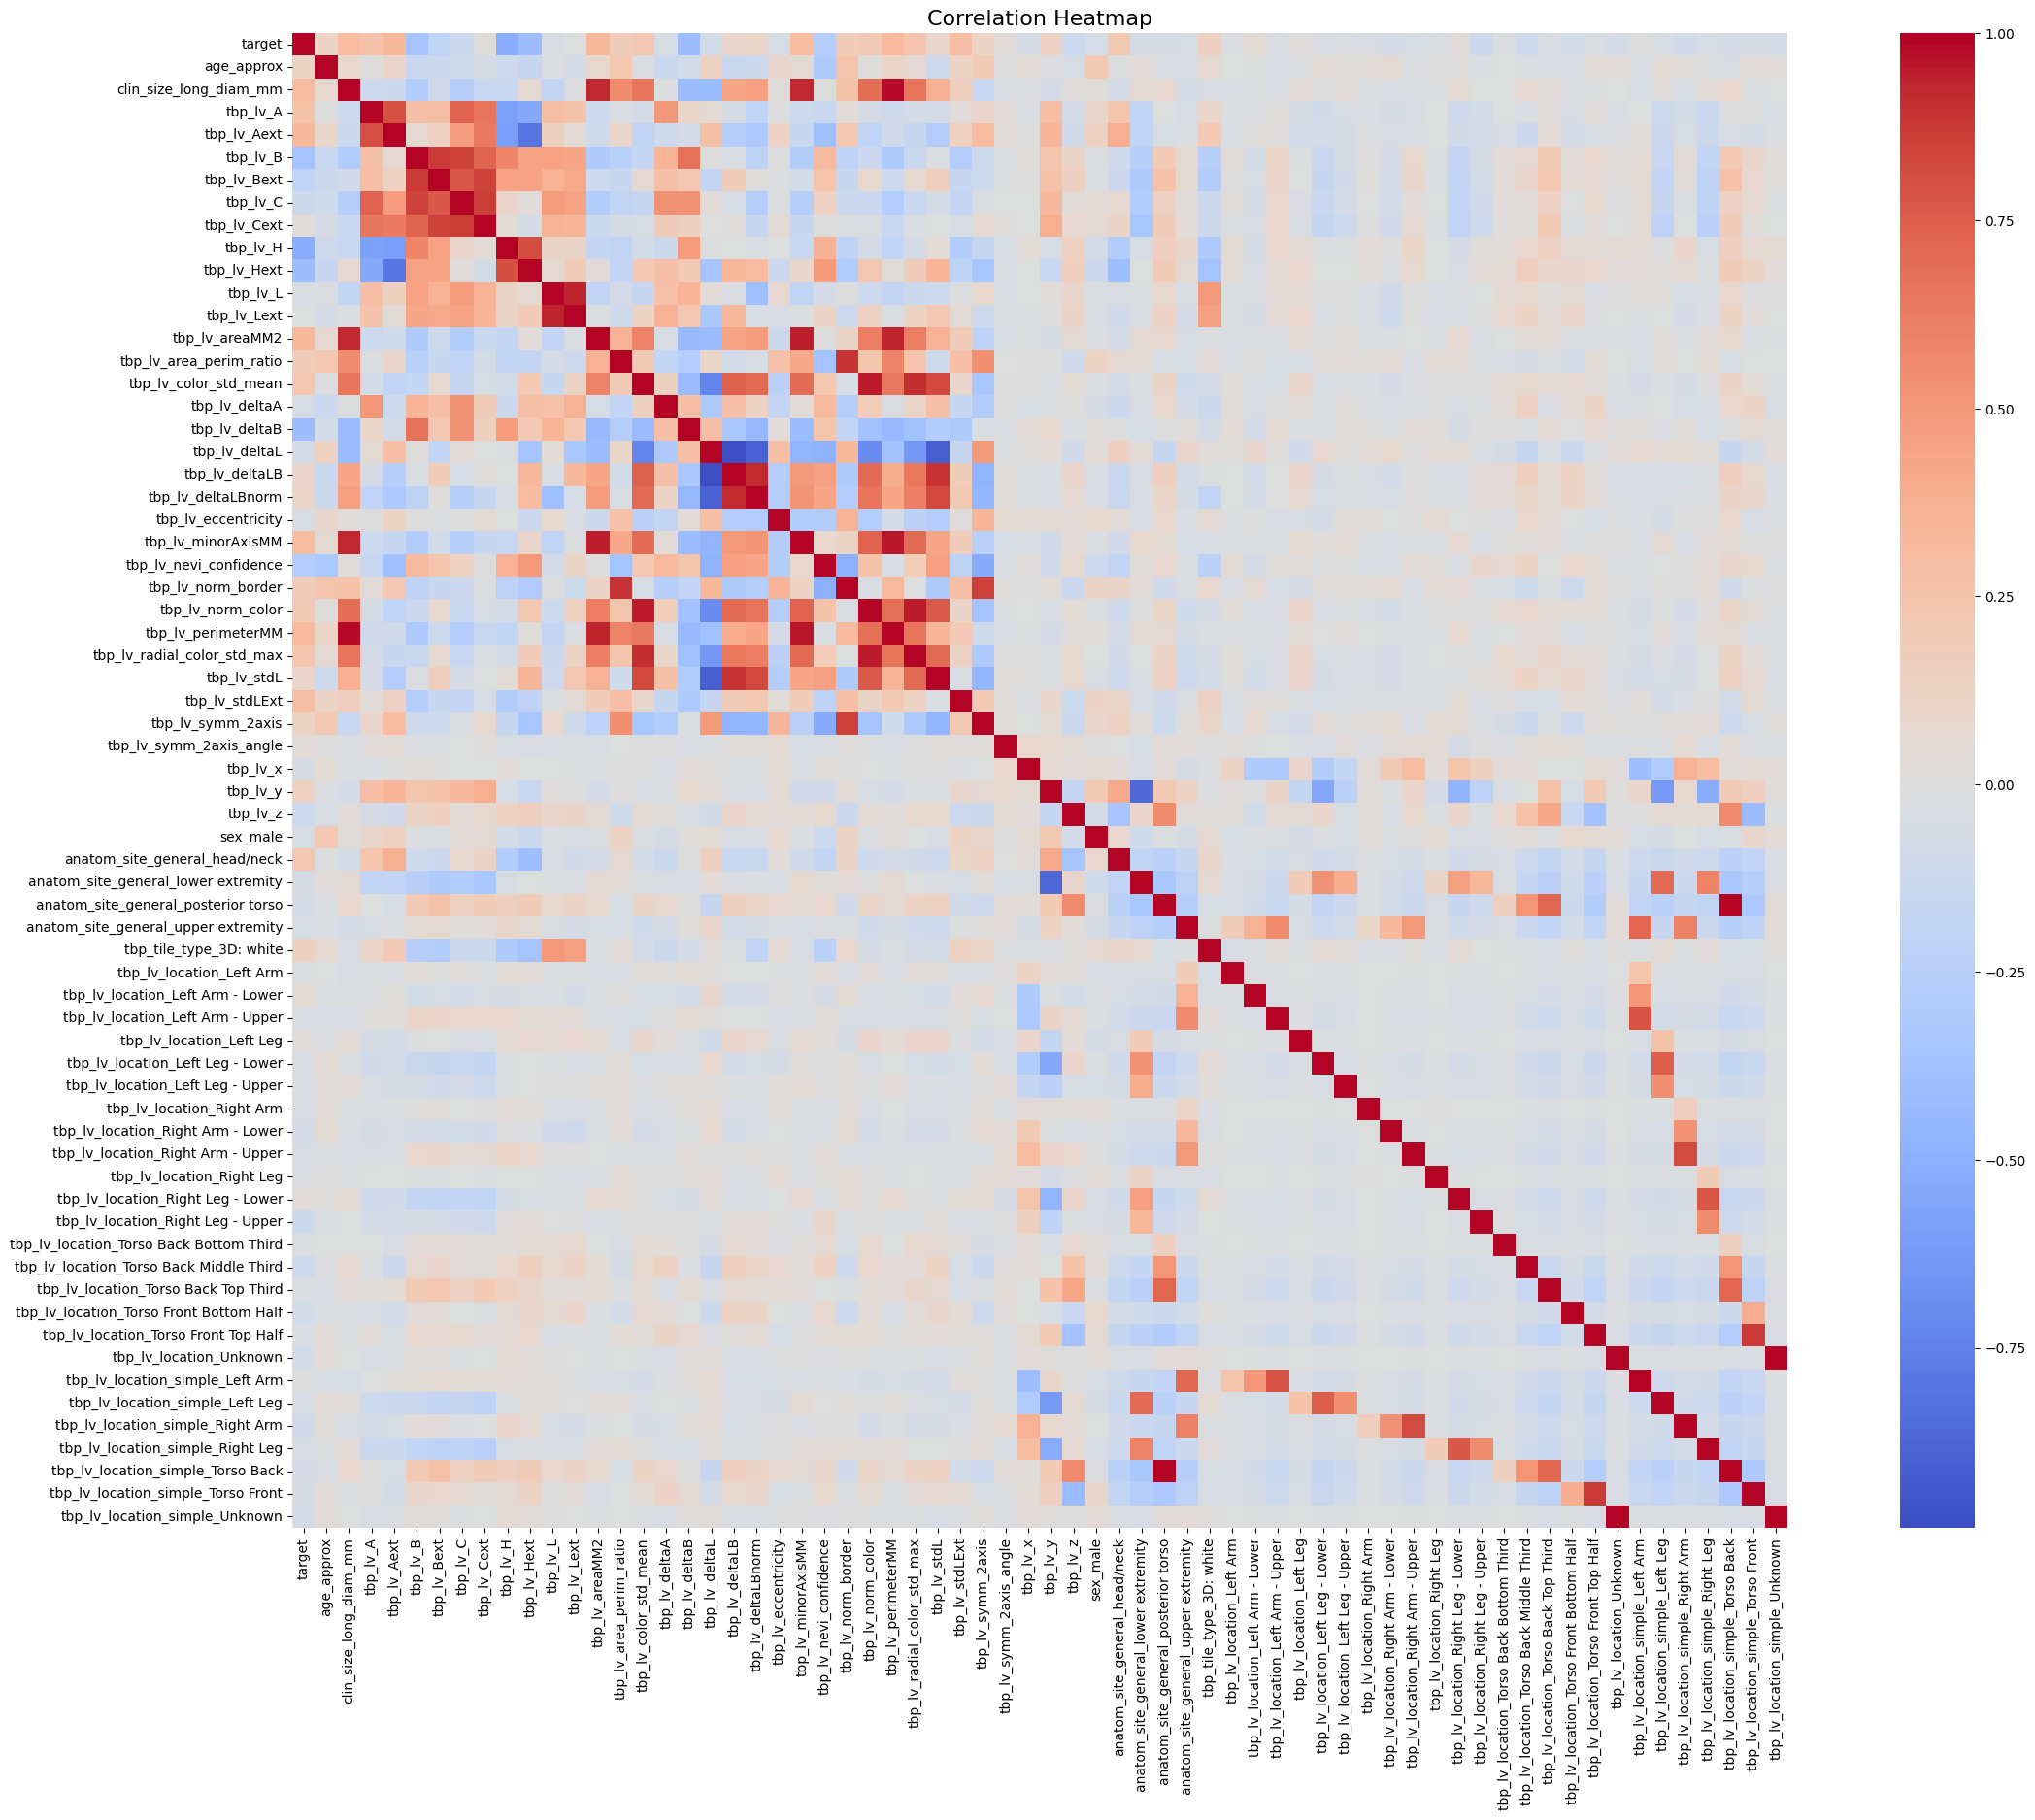

In [96]:
# Calculate the correlation matrix
correlation_matrix = resampled_df.drop('isic_id', axis = 1).corr()

# Create a larger figure for the heatmap
plt.figure(figsize=(30,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, cbar=True, center = 0)

# Set the title
plt.title('Correlation Heatmap', fontsize=16)
plt.savefig('heatmap.jpg')
plt.show()

In [97]:
# Get correlation with the target variable
correlation_matrix = resampled_df.drop('isic_id', axis = 1).corr()
target_corr = correlation_matrix['target'].sort_values(ascending=False)
target_corr

target                    1.000000
tbp_lv_Aext               0.329139
tbp_lv_areaMM2            0.328090
tbp_lv_perimeterMM        0.314281
tbp_lv_minorAxisMM        0.303769
                            ...   
tbp_lv_nevi_confidence   -0.267311
tbp_lv_B                 -0.361847
tbp_lv_Hext              -0.409235
tbp_lv_deltaB            -0.411462
tbp_lv_H                 -0.507820
Name: target, Length: 66, dtype: float64

In [26]:
# Keep only features with high correlation to the target
selected_features = target_corr[target_corr.abs() > 0.1].index
# Add 'sex' to the selected features list
selected_features = ['isic_id'] + selected_features.tolist() + ['sex_male'] 
resampled_df = resampled_df[selected_features]
resampled_df

,isic_id,target,tbp_lv_Aext,tbp_lv_areaMM2,tbp_lv_perimeterMM,tbp_lv_minorAxisMM,clin_size_long_diam_mm,tbp_lv_stdLExt,tbp_lv_A,tbp_lv_radial_color_std_max,...,tbp_lv_z,tbp_lv_C,tbp_lv_location_Right Leg - Upper,tbp_lv_Bext,tbp_lv_nevi_confidence,tbp_lv_B,tbp_lv_Hext,tbp_lv_deltaB,tbp_lv_H,sex_male
0,ISIC_7745168,1,14.449421,70.669919,47.664146,7.283754,13.470000,2.493924,17.562551,2.118797,...,98.889099,27.546667,0,22.026133,9.257946e-05,21.222056,56.734619,-0.804077,50.390161,1
1,ISIC_5265088,0,20.164393,4.316007,8.806065,1.945750,2.930000,2.025815,21.976708,1.022370,...,43.441467,31.808858,0,23.166859,1.833790e+00,22.996255,48.963748,-0.170604,46.298686,1
2,ISIC_4034820,0,16.357560,5.010321,8.759058,2.310409,2.660000,1.826579,17.680250,1.204543,...,144.686300,26.708150,0,24.539160,4.318154e+01,20.018350,56.312970,-4.520804,48.549000,1
3,ISIC_1186361,1,14.769880,20.135110,26.678400,4.737949,7.120000,2.317288,18.964410,0.744512,...,44.082030,26.468960,0,20.541780,3.041118e-01,18.465020,54.283240,-2.076757,44.235590,0
4,ISIC_7676691,1,29.418980,0.844436,3.193659,0.684932,1.230000,1.802801,34.033000,0.000000,...,31.051330,41.991590,0,22.139230,6.091658e-07,24.597730,36.963260,2.458497,35.857940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,None,1,27.373575,1.370643,4.408639,0.973810,1.499375,3.160239,34.447768,0.019943,...,22.228666,44.697666,0,25.253174,3.004952e+00,28.425127,43.337316,3.171953,39.913154,1
1196,None,1,18.314043,2.232059,5.677908,1.156982,2.109957,2.277878,20.745934,0.170612,...,32.876359,29.972989,0,20.693706,1.762264e-01,21.580353,48.779095,0.886647,46.629476,0
1197,None,1,16.226996,73.190312,42.198755,7.852871,13.342536,6.573964,14.119428,1.490848,...,84.862609,20.657147,0,23.028745,1.177852e-01,15.048566,54.889545,-7.980182,47.428029,1
1198,None,1,17.370449,1.209792,4.225590,0.855396,1.663010,2.426099,20.890353,0.038529,...,112.379129,31.197724,0,22.605935,7.702284e-03,23.167622,52.584779,0.561688,48.012797,0


# Image Data Preprocessing

In [27]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load only the images that are in 'isic_ids'
image_list = glob('/kaggle/input/isic-2024-challenge/train-image/image/*.jpg')  

image_ids = []
images = []
image_sizes = []
image_labels = []
for image_path in image_list:
    image_name = image_path.split('/')[-1].split('.')[0]  # Extract image name without extension
    if image_name in set(isic_ids):
        image_ids.append(image_name)
        img = load_img(image_path)  # Load image as RGB without resizing
        image_sizes.append(img.size)  # Store original image size (width, height)
        # Get the corresponding label from the metadata
        label = metadata.loc[metadata['isic_id'] == image_name, 'target'].values[0]  # Get the label
        image_labels.append(label)
        
        # Now resize to 150x150
        img_array = img_to_array(img)  # Convert to NumPy array (150x150x3)
        img_array = img_array / 255.0  # Normalize pixel values to range [0, 1]
        images.append(img_array)

# Convert list of images to NumPy array (Shape will be [num_images, 150, 150, 3])
images = np.array(images)
image_ids = pd.Series(image_ids)
image_labels = np.array(image_labels)

In [29]:
pd.Series(image_sizes).value_counts()

(131, 131)    62
(129, 129)    62
(121, 121)    52
(133, 133)    48
(135, 135)    48
(137, 137)    41
(123, 123)    40
(139, 139)    39
(127, 127)    37
(125, 125)    37
(143, 143)    36
(119, 119)    35
(113, 113)    35
(141, 141)    35
(115, 115)    32
(117, 117)    30
(145, 145)    28
(147, 147)    25
(111, 111)    20
(151, 151)    19
(149, 149)    19
(155, 155)    18
(153, 153)    17
(107, 107)    17
(105, 105)    16
(101, 101)    13
(161, 161)    12
(157, 157)    12
(99, 99)      12
(163, 163)    11
(109, 109)    11
(103, 103)    10
(97, 97)       7
(159, 159)     7
(165, 165)     7
(171, 171)     5
(167, 167)     5
(95, 95)       4
(191, 191)     3
(89, 89)       3
(215, 215)     2
(91, 91)       2
(181, 181)     2
(179, 179)     2
(173, 173)     2
(205, 205)     2
(195, 195)     1
(81, 81)       1
(169, 169)     1
(187, 187)     1
(175, 175)     1
(87, 87)       1
(201, 201)     1
(197, 197)     1
(193, 193)     1
(189, 189)     1
(185, 185)     1
Name: count, dtype: int64

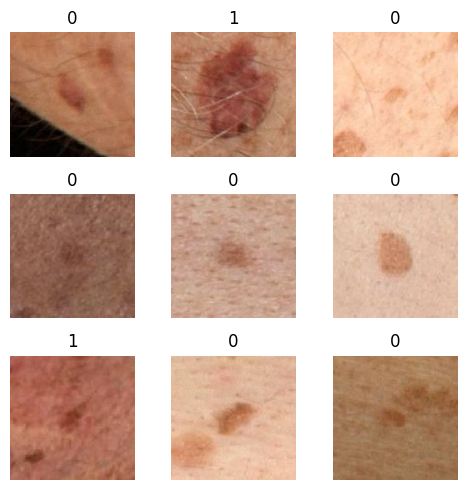

In [108]:
# display sample images
def display_sample_images(images, image_labels, num_samples=9):
    plt.figure(figsize=(5,5))
    num_samples = min(num_samples, len(images))

    for i in range(num_samples):
        plt.subplot(3, 3, i + 1) 
        plt.imshow(images[i])  
        plt.title(image_labels[i])  
        plt.axis('off')
    
    plt.tight_layout() 
    plt.show()

display_sample_images(images, image_labels)

In [31]:
images.shape

(993, 150, 150, 3)

## Minority Class Image Augmentation

In [123]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Identify the minority class indices
minority_class_indices = np.where(image_labels == 1)[0]  

# Extract minority class images
minority_images = images[minority_class_indices]

# Create an instance of ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment images
augmented_images = []
num_augmentations = 1200 - len(images) + 1 # Total desired images - current images
num_augmentations_per_image = num_augmentations // len(minority_images)  # Average number of augmentations per image

for img in minority_images:
    img = img.reshape((1,) + img.shape)  # Reshape image to (1, height, width, channels)
    
    # Generate augmented images
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])  # Append augmented image to the list
        if len(augmented_images) >= num_augmentations:  # Stop when reaching desired number
            break

# Convert augmented images to a NumPy array
augmented_images = np.array(augmented_images)

# Combine augmented minority images with original majority class images
majority_class_indices = np.where(image_labels == 0)[0]  # Assuming 0 is the majority class
majority_images = images[majority_class_indices]

# Combine both
all_images = np.concatenate((majority_images, augmented_images), axis=0)

# create new labels for augmented images
new_labels = np.concatenate((np.zeros(len(majority_images)), np.ones(len(augmented_images))), axis=0)
new_ids = np.concatenate((image_ids[majority_class_indices], image_ids[minority_class_indices], pd.Series([None] * 207)), axis=0)

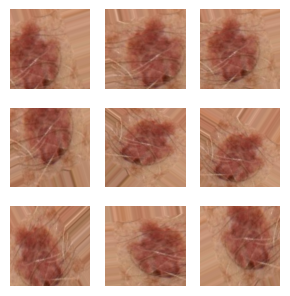

In [124]:
display_sample_images(augmented_images)

In [33]:
# Create a mapping from isic_id to its index in resampled_df
id_to_index = {id_: index for index, id_ in enumerate(resampled_df['isic_id'])}

# Create a new index based on the order of image_ids
ordered_indices = [id_to_index[id_] for id_ in new_ids if id_ in id_to_index]

# Reorder the resampled_df using the ordered indices
reordered_resampled_df = resampled_df.iloc[ordered_indices].reset_index(drop=True)

In [34]:
# Convert the target column of the DataFrame to a NumPy array
target_labels = reordered_resampled_df['target'].values

# Check if the lengths match
if len(new_labels) == len(target_labels):
    # Count the number of exact matches
    matching_indices = np.where(new_labels == target_labels)[0]  # Get indices where they match
    num_matches = len(matching_indices)

    print(f"Number of matching labels: {num_matches}")
else:
    print("The lengths of image labels and target column do not match.")


Number of matching labels: 1200


# Splitting data

In [35]:
new_labels = pd.Series(new_labels)
# Split the data
Ximg_train, Ximg_test, yimg_train, yimg_test = train_test_split(all_images, new_labels, test_size=0.2, random_state=42, stratify=new_labels)

# Split the metadata using the same indices 
train_indices = yimg_train.index
test_indices = yimg_test.index

# Slicing the reordered_resampled_df to get the corresponding rows
train_metadata = reordered_resampled_df.iloc[train_indices]
test_metadata = reordered_resampled_df.iloc[test_indices]

Xtab_train = train_metadata.drop(['isic_id','target'], axis = 1)
ytab_train = train_metadata['target']
Xtab_test = test_metadata.drop(['isic_id','target'], axis = 1)
ytab_test = test_metadata['target']

In [36]:
print(f'Train images: {Ximg_train.shape}')
print(f'Train image labels: {yimg_train.shape}')
print(f'Train metadata: {Xtab_train.shape}')
print(f'Train metadata labels: {ytab_train.shape}')
print(f'Test images: {Ximg_test.shape}')
print(f'Test image labels: {yimg_test.shape}')
print(f'Test metadata: {Xtab_test.shape}')
print(f'Test metadata labels: {ytab_test.shape}')

Train images: (960, 150, 150, 3)
Train image labels: (960,)
Train metadata: (960, 29)
Train metadata labels: (960,)
Test images: (240, 150, 150, 3)
Test image labels: (240,)
Test metadata: (240, 29)
Test metadata labels: (240,)


## Tabular Features Scaling

In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtab_train_scaled = scaler.fit_transform(Xtab_train)
Xtab_test_scaled = scaler.transform(Xtab_test)
print(Xtab_train_scaled)

[[0.3460278  0.04288577 0.10421487 ... 0.58675645 0.83190453 1.        ]
 [0.20997948 0.07267871 0.14564403 ... 0.72281213 0.91743914 1.        ]
 [0.32063734 0.01816967 0.06013969 ... 0.74074813 0.91413971 1.        ]
 ...
 [0.38530406 0.11596526 0.20842981 ... 0.5105908  0.64954966 1.        ]
 [0.48741005 0.06559786 0.13815983 ... 0.63228807 0.71809777 0.        ]
 [0.3182014  0.01897128 0.08040026 ... 0.71110387 0.85810232 0.        ]]


In [38]:
from sklearn.utils import shuffle
# Shuffle the image and tabular training data together
Ximg_train_shuffled, Xtab_train_shuffled, y_train_shuffled = shuffle(Ximg_train, Xtab_train_scaled, yimg_train, random_state=42)
Ximg_test_shuffled, Xtab_test_shuffled, y_test_shuffled = shuffle(Ximg_test, Xtab_test_scaled, yimg_test, random_state=42)

# Model Architecture

In [39]:
from tensorflow.keras import layers, models, Input

# Image input branch
image_input = Input(shape=(150, 150, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

# Tabular data input branch
tabular_input = Input(shape=(Xtab_train_scaled.shape[1],), name='tabular_input')
y = layers.Dense(64, activation='relu')(tabular_input)
y = layers.Dense(32, activation='relu')(y)

# Concatenate both branches
combined = layers.concatenate([x, y])

# Output layer
output = layers.Dense(1, activation='sigmoid')(combined)  # For binary classification

# Define the model
model = models.Model(inputs=[image_input, tabular_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,920 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 82944)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 82976)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │     82,977 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,369 (415.50 KB)

 Trainable params: 106,369 (415.50 KB)

 Non-trainable params: 0 (0.00 B)

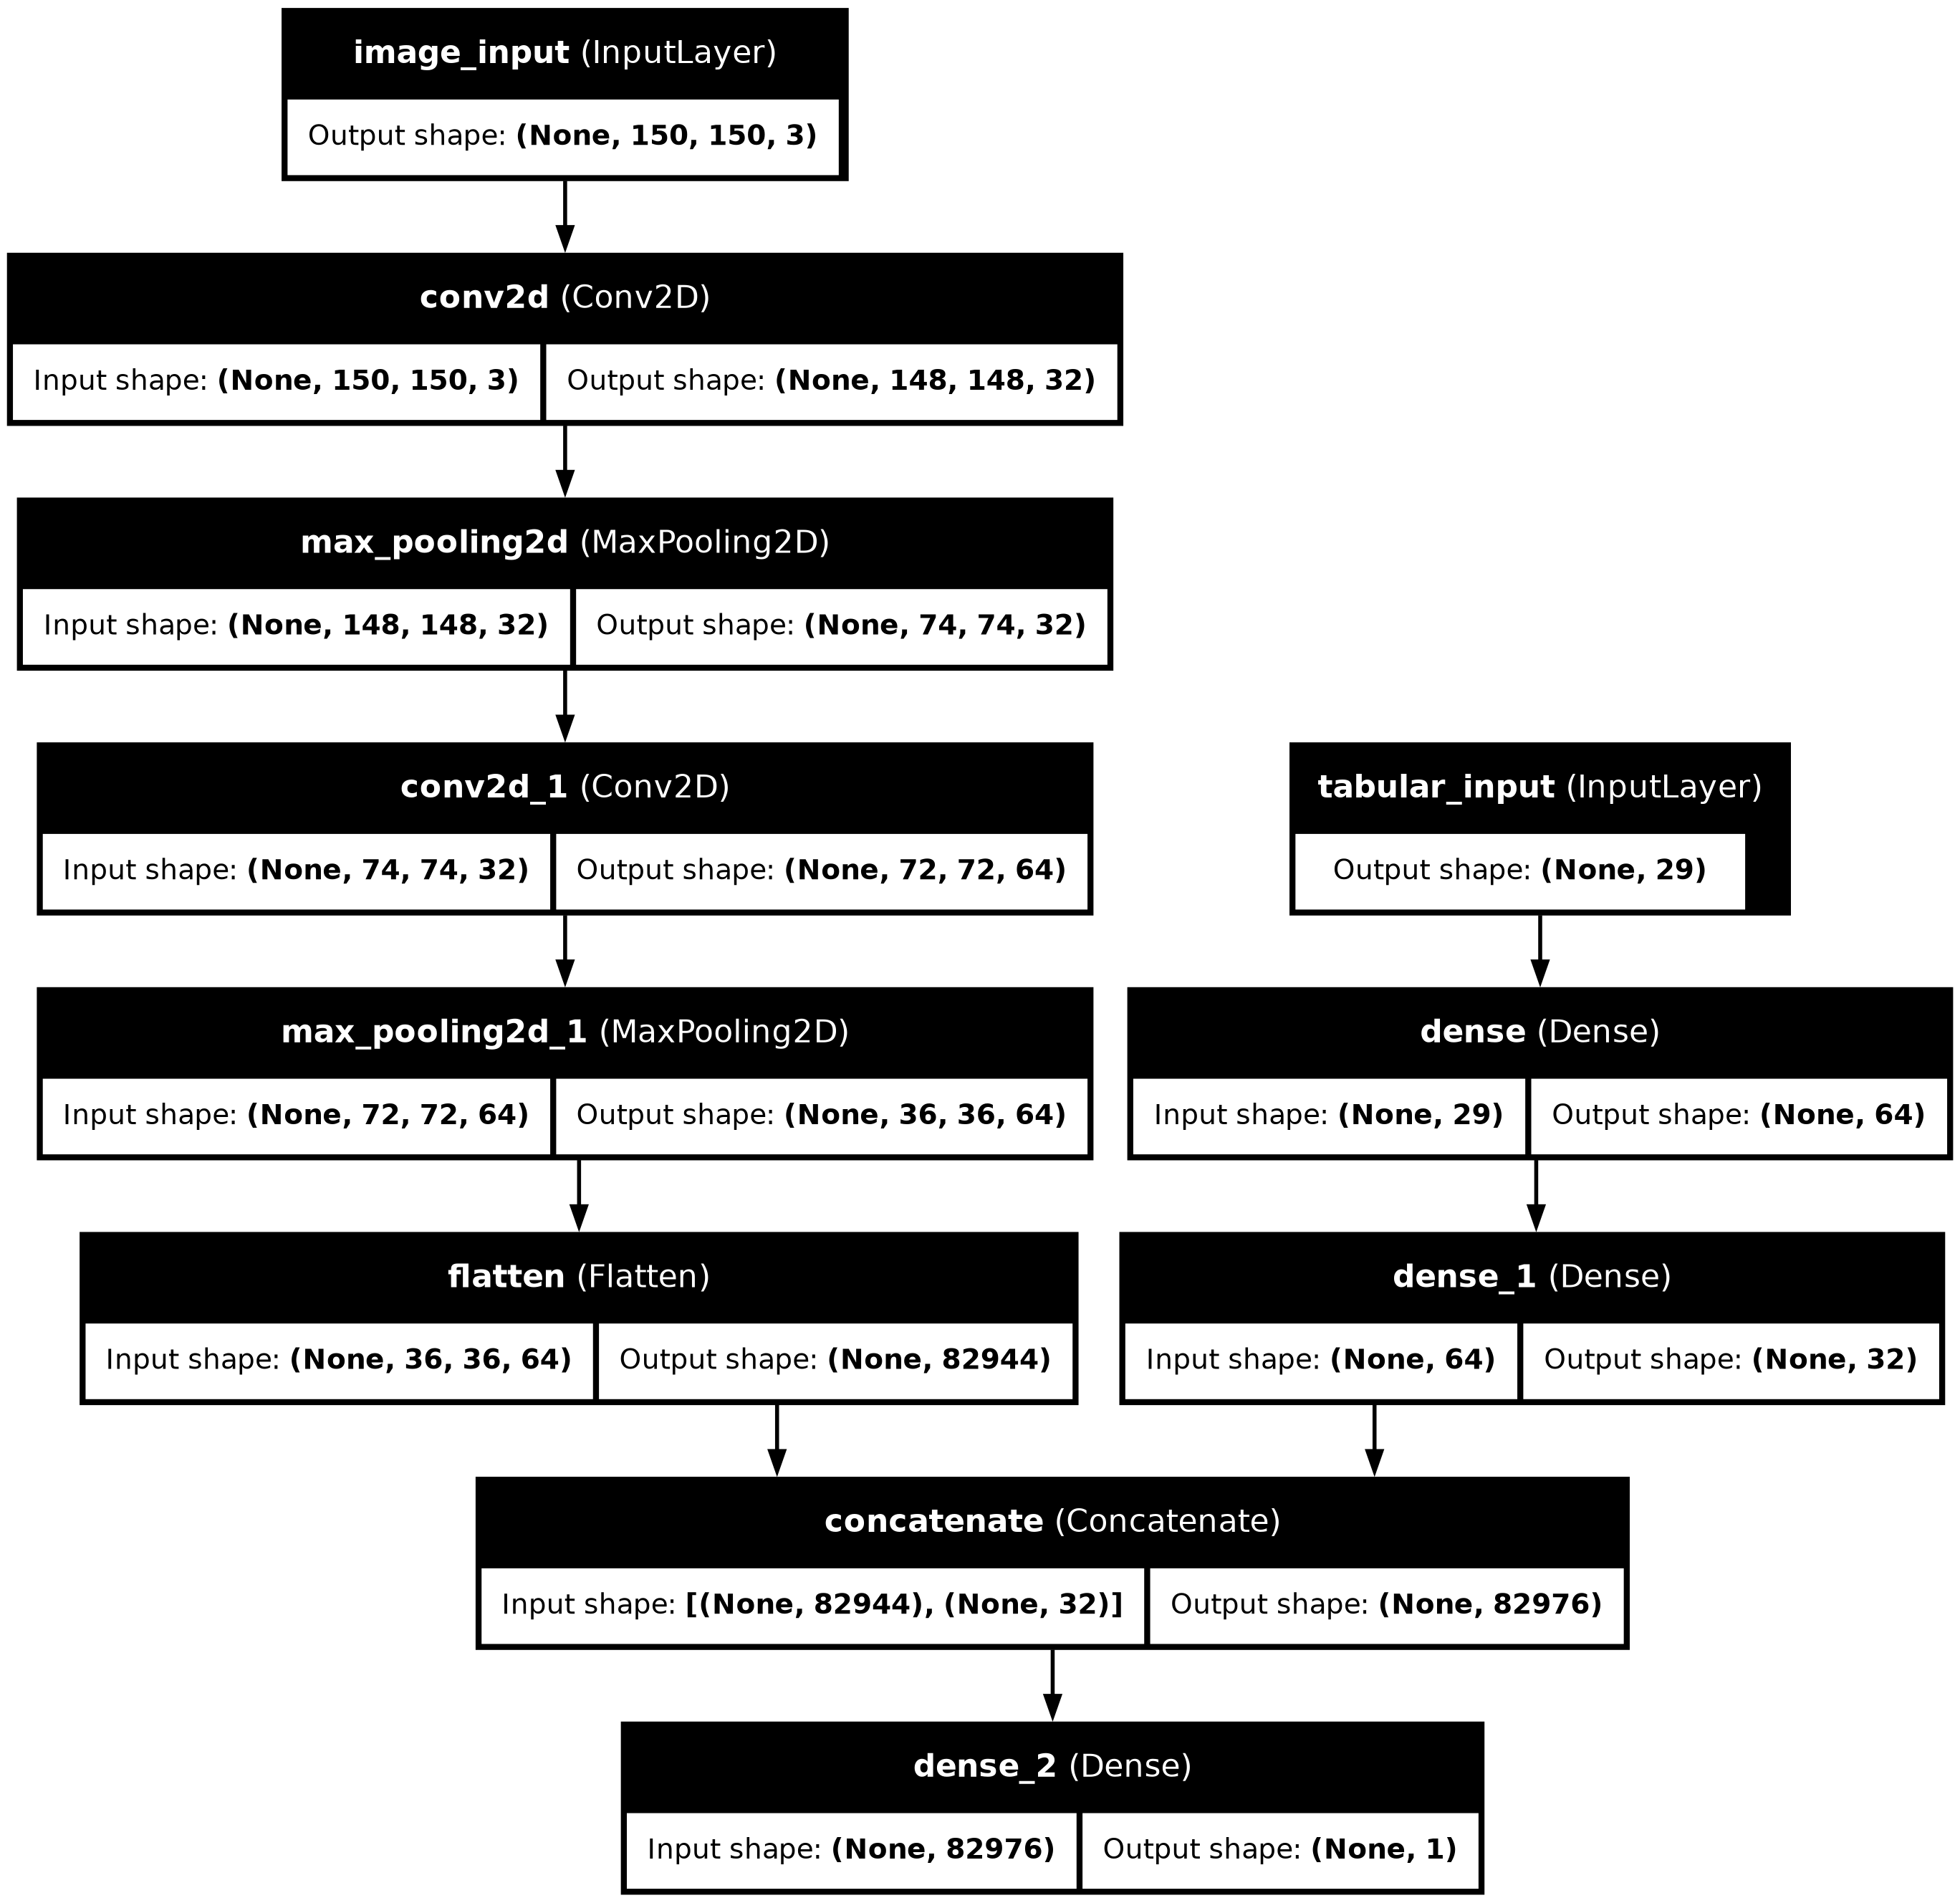

In [40]:
# Plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Model Fitting

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=5,           # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restore the weights of the best epoch)
num_epochs = 50 
# Fit the model with early stopping
history = model.fit(
    {'image_input': Ximg_train_shuffled, 'tabular_input': Xtab_train_shuffled},  # Inputs
    y_train_shuffled,  # Labels
    epochs=num_epochs,
    validation_split=0.2,  # Use 20% of the training data for validation
    callbacks=[early_stopping],  # Add early stopping
    batch_size=32  # Batch size )

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 637ms/step - accuracy: 0.5060 - loss: 0.8206 - val_accuracy: 0.6719 - val_loss: 0.6325
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.6625 - loss: 0.6343 - val_accuracy: 0.7604 - val_loss: 0.4699
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 584ms/step - accuracy: 0.8082 - loss: 0.4652 - val_accuracy: 0.8906 - val_loss: 0.2773
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 617ms/step - accuracy: 0.8814 - loss: 0.3067 - val_accuracy: 0.9010 - val_loss: 0.2769
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 585ms/step - accuracy: 0.9220 - loss: 0.2363 - val_accuracy: 0.9010 - val_loss: 0.2742
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 625ms/step - accuracy: 0.9223 - loss: 0.2462 - val_accuracy: 0.9427 - val_loss: 0.1951
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 584ms/step - accuracy: 0.9112 - loss: 0.2356 - val_accuracy: 0.9323 - val_loss: 0.1997
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 644ms/step - accuracy: 0.9222 - loss: 0.1956 - val_accu

# Model Performance Evaluation

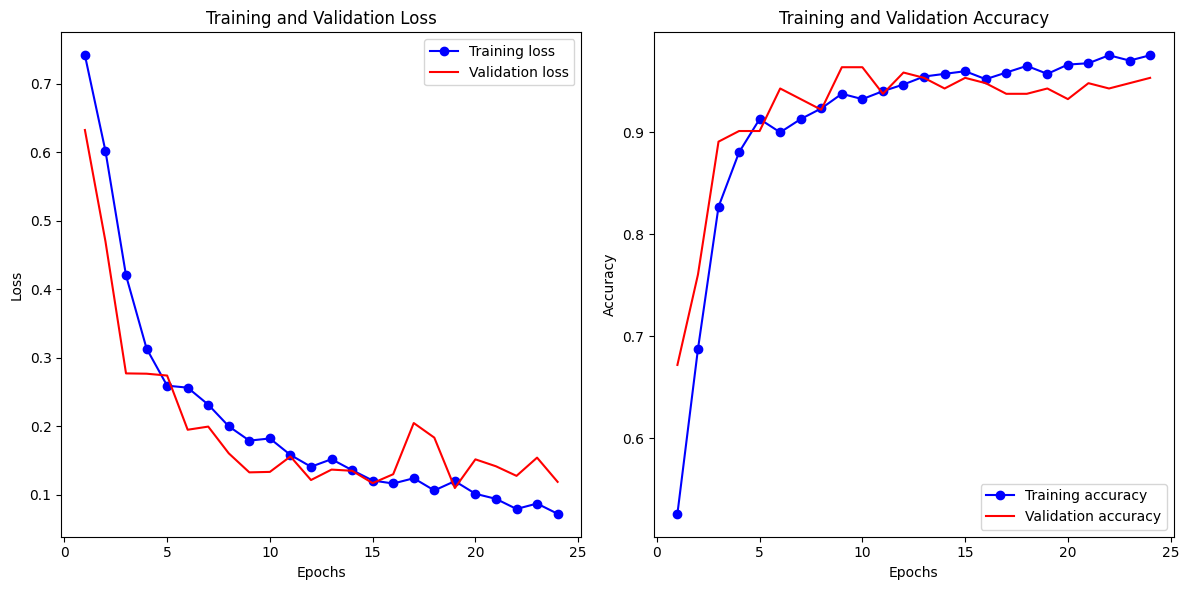

In [42]:
import matplotlib.pyplot as plt

# Extract the history of loss and accuracy
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy_values, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [43]:
test_loss, test_accuracy = model.evaluate(
    {'image_input': Ximg_test_shuffled, 'tabular_input': Xtab_test_shuffled}, 
    y_test_shuffled )
print("Test accuracy:", test_accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9465 - loss: 0.2092
Test accuracy: 0.9458333253860474


# Model Testing

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


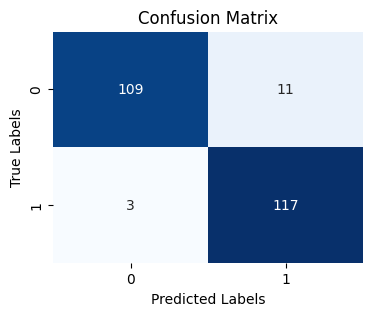

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
# Predict the probabilities
y_pred_probs = model.predict([Ximg_test_shuffled, Xtab_test_shuffled])
threshold = 0.3
y_pred = (y_pred_probs > threshold).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test_shuffled, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [45]:
# Print classification report
print(classification_report(y_test_shuffled, y_pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.97      0.91      0.94       120
     Class 1       0.91      0.97      0.94       120

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240



In [158]:
model.save('best_model.h5')